# Imports

In [1]:
#science imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy import stats

#standard library imports
import copy
import glob
import os
import os.path as path
import time

#PyMca imports
from PyMca5.PyMca import McaAdvancedFitBatch as batch
from PyMca5.PyMcaPhysics.xrf.XRFBatchFitOutput import OutputBuffer

# Set path label for file reading
This is the YYYYMMDD_CVD_XXXX label at the beginning of the XRF map folder.

In [2]:
#this just allows easy folder selection so you don't have to copy the name from the file browser

folders = glob.glob("*_map")



for i in range(0, len(folders)):
    print("{0:<2d} - {1:s}".format(i, folders[i]))

0  - 20230531_CVD_3076_map
1  - 20230531_CVD_3158_map
2  - 20230606_CVD_2555_map
3  - 20230607_CVD_2546_map
4  - 20230607_CVD_2802_map
5  - 20230613_CVD_2808_map
6  - 20230613_CVD_3496_map
7  - 20230621_CVD_2566_map
8  - 20230621_CVD_2808_map
9  - 20230623_CVD_2566_map
10 - 20230626_CVD_2808_map
11 - 20230627_CVD_2546_map
12 - 20230628_CVD_2546_map


In [3]:
path_label = folders[1][0:-4]

sample_name = "CVD" + path_label[-4:]

# PyMca batch fitting

# File reading

## Prepare data arrays
Determine grid resolution and create empty data arrays in preparation for reading

In [4]:
#set number of points and dimensions of scan
#grid_size is number of steps in the grid x and y axes
#grid_dim is the actual length of the sides of the square scanned by the grid, in mm

if len(glob.glob("./"+path_label+"_map/*.spx")) == 200:
    grid_size = 10
    grid_dim = 15
elif len(glob.glob("./"+path_label+"_map/*.spx")) == 800:
    grid_size = 20
    grid_dim = 0.5
else:
    raise FileNotFoundError("Folder contains neither 200 nor 800 .spx files.")

print("{0}x{0} grid".format(grid_size))

#dat["Xx_Yy_dZ"] contains data from element Xx, characteristic line Yy, detector Z
dat = {
    "Si_ka_d1": np.zeros((grid_size, grid_size)),
    "Si_ka_d2": np.zeros((grid_size, grid_size)),
    "Ga_ka_d1": np.zeros((grid_size, grid_size)),
    "Ga_ka_d2": np.zeros((grid_size, grid_size)),
    "Ga_kb_d1": np.zeros((grid_size, grid_size)),
    "Ga_kb_d2": np.zeros((grid_size, grid_size)),
    "Ga_l_d1":  np.zeros((grid_size, grid_size)),
    "Ga_l_d2":  np.zeros((grid_size, grid_size)),
    "P_ka_d1":  np.zeros((grid_size, grid_size)),
    "P_ka_d2":  np.zeros((grid_size, grid_size))
}

10x10 grid


## PyMca
Format is ;-separated csv file. First row is headers. The first two columns are a row and column entry. PyMca assumes that your data are in a grid but it doesn't know how our data are arranged, so it just dumps them all into a list of rows. Thankfully, the list has all our data ordered 0_0, 0_1, 0_2, etc. This means the row number can be used to determine the x and y coordinates of the spectrum with a bit of math. The y coordinate is row # mod 10, and the x coordinate is (row number / 10) mod 10. For grids with a different size (e.g. 20x20) the 10 is replaced with the size of the grid.

In [5]:
source = "PyMca"

#glob can be used here because there is only one csv file, and it is useful in case the file name format changes
input_file = open(glob.glob("./" + path_label + "_map/fits_out/IMAGES/*.csv")[0], "r")

s = input_file.readline().split(";")

while s != [""]:
    
    #only read lines that start with a number
    #also, only read lines in column zero. When PyMca does batch fits on .spx
    #files, it will interpret the SNIP background from the bruker software as
    #its own spectrum, and fit both the actual spectrum and the background as
    #though they were both spectra. When it does this, the csv file contains
    #peak areas from the actual spectrum in column 0, and peak areas from the
    #background in column 1.
    if s[0][0].isnumeric() and s[1] == "0": 
        
        index = int(s[0]) #file index is first in the line
        x = int(((index)/grid_size) % grid_size)
        y = int((index) % grid_size)
        
        si_counts = float(s[2])
        ga_ka_counts = float(s[8])
        ga_kb_counts = float(s[9])
        #combine data from La1, La2, La3 since they are indistuinguishable with Si(Li) detector
        ga_l_counts = float(s[10]) + float(s[11]) + float(s[12])
        p_counts = float(s[4])
        
        if int(s[0]) < grid_size**2 : #separate into detector 1 and detector 2
            dat["Si_ka_d1"][y][x] = si_counts
            dat["Ga_ka_d1"][y][x] = ga_ka_counts
            dat["Ga_kb_d1"][y][x] = ga_kb_counts
            dat["Ga_l_d1"][y][x] = ga_l_counts
            dat["P_ka_d1"][y][x] = p_counts
            
        elif int(s[0]) >= grid_size**2:
            dat["Si_ka_d2"][y][x] = si_counts
            dat["Ga_ka_d2"][y][x] = ga_ka_counts
            dat["Ga_kb_d2"][y][x] = ga_kb_counts
            dat["Ga_l_d2"][y][x] = ga_l_counts
            dat["P_ka_d2"][y][x] = p_counts

    s = input_file.readline().split(";")
        
input_file.close()

## Create 1-dimensional data arrays
`vec` will be used for operations that require data in a 1d array, specifically stats and probability plots.

In [6]:
vec = dat.copy()
#n.b. this is a SHALLOW copy
for key, val in vec.items():
    vec[key] = val.reshape(grid_size**2)

# Ensure results folder exists
And create one if it doesn't

In [7]:
if not path.exists("./" + path_label + "_map/results_out"):
    print("didn't find results_out, creating folder")
    os.mkdir("./" + path_label + "_map/results_out")

# Statistical Processing
This routine calculates the average and standard deviation of the data. It also trims off data with z-scores too far from zero and calculates the average and standard deviation of those as well.

In [13]:
trim_threshold = 2

def getStats(ar, thr):
    """calculate and return statistical properties of ar

    ar will be trimmed to remove data with |z| > thr

    ar must be a 1d array
    """
    av = np.average(ar)
    std = np.std(ar)

    z = np.abs((ar - av) / std) # z-score of each element of ar
    mask = np.invert(np.array(z//thr, dtype=bool)) #mask[i] is true only if z[i] >= thr
    trim = ar[mask] #trim includes only elements ar[i] such that z[i] >= thr

    av_trim = np.average(trim)
    std_trim = np.std(trim)

    return av, std, av_trim, std_trim

#format string to be used for writing to files and stdio
row_format = "{0}\t{1}\t{2}\t{3[0]:.0f}\t{3[1]:.0f}\t{3[2]:.0f}\t{3[3]:.0f}"

print(sample_name + " Statistics, " + source)
print("Trim threshold: z >= " + str(trim_threshold))
print("\t\t\t\ttrimmed\ttrimmed")
print("Signal\tDet.\tLine\tAvg\tSTD\tavg\tstd")

print(row_format.format("Si", "d1", "Ka", getStats(vec["Si_ka_d1"], trim_threshold)))
print(row_format.format("Si", "d2", "Ka", getStats(vec["Si_ka_d2"], trim_threshold)))
print(row_format.format("Ga", "d1", "Ka", getStats(vec["Ga_ka_d1"], trim_threshold)))
print(row_format.format("Ga", "d2", "Ka", getStats(vec["Ga_ka_d2"], trim_threshold)))
print(row_format.format("Ga", "d1", "Kb", getStats(vec["Ga_kb_d1"], trim_threshold)))
print(row_format.format("Ga", "d2", "Kb", getStats(vec["Ga_kb_d2"], trim_threshold)))
print(row_format.format("Ga", "d1", "L", getStats(vec["Ga_l_d1"], trim_threshold)))
print(row_format.format("Ga", "d2", "L", getStats(vec["Ga_l_d2"], trim_threshold)))
print(row_format.format("P", "d1", "Ka", getStats(vec["P_ka_d1"], trim_threshold)))
print(row_format.format("P", "d2", "Ka", getStats(vec["P_ka_d2"], trim_threshold)))

CVD3158 Statistics, PyMca
Trim threshold: z >= 2
				trimmed	trimmed
Signal	Det.	Line	Avg	STD	avg	std
Si	d1	Ka	361840	1274	361932	1051
Si	d2	Ka	377848	1471	378068	1135
Ga	d1	Ka	14286	155	14283	133
Ga	d2	Ka	14598	155	14591	147
Ga	d1	Kb	2001	110	2006	100
Ga	d2	Kb	2064	118	2061	110
Ga	d1	L	659	48	657	41
Ga	d2	L	760	53	760	51
P	d1	Ka	4734	91	4731	84
P	d2	Ka	4754	67	4754	60


In [14]:
#write results to file
stats_out_file = open("./" + path_label + "_map/results_out/" + path_label + "_stats_" + source + ".txt", "w")

stats_out_file.write(sample_name + " Statistics, " + source + "\n")
stats_out_file.write("Trim threshold: z >= " + str(trim_threshold) + "\n")
stats_out_file.write("\t\t\t\ttrimmed\ttrimmed\n")
stats_out_file.write("Signal\tDet.\tLine\tAvg\tSTD\tavg\tstd\n")

#write() needs a \n at the end
stats_out_file.write(row_format.format("Si", "d1", "Ka", getStats(vec["Si_ka_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Si", "d2", "Ka", getStats(vec["Si_ka_d2"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d1", "Ka", getStats(vec["Ga_ka_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d2", "Ka", getStats(vec["Ga_ka_d2"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d1", "Kb", getStats(vec["Ga_kb_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d2", "Kb", getStats(vec["Ga_kb_d2"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d1", "L", getStats(vec["Ga_l_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("Ga", "d2", "L", getStats(vec["Ga_l_d2"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("P", "d1", "Ka", getStats(vec["P_ka_d1"], trim_threshold)) + "\n")
stats_out_file.write(row_format.format("P", "d2", "Ka", getStats(vec["P_ka_d2"], trim_threshold)) + "\n")

stats_out_file.close()

# Probability plots
This routine makes normal probability plots for the data. These can be used to assess if the data is normally distributed or not. It's also just a good way to visualize the distribution.

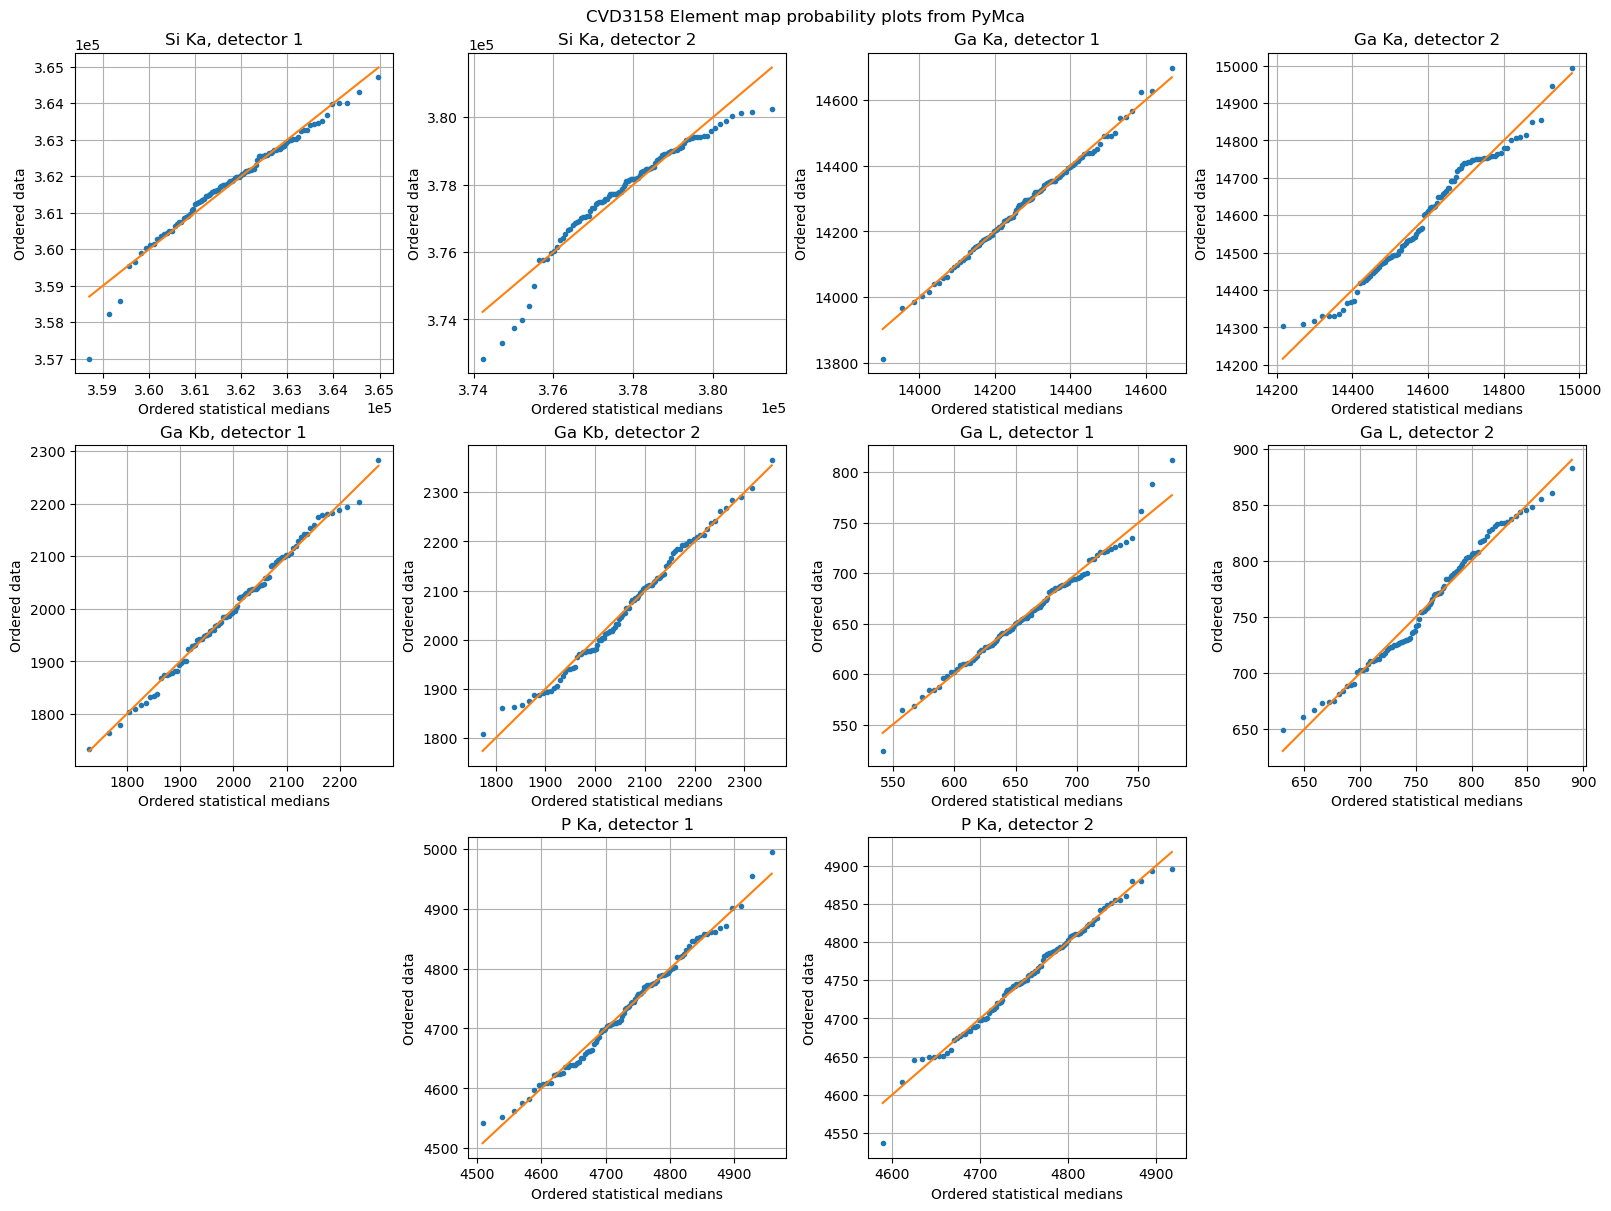

In [10]:
def probPlot(ax, dat, title):
    
    osm, osr = stats.probplot(dat, (np.average(dat), np.std(dat)), dist="norm", fit=False)
    ax.plot(osm, osr, ".") #plot data
    ax.plot(osm, osm, "-") #plot line y=x
    ax.grid(True)
    ax.ticklabel_format(scilimits=(-5,5))
    ax.set_title(title)
    ax.set_xlabel("Ordered statistical medians")
    ax.set_ylabel("Ordered data")

f, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (16, 12), layout="constrained")

probPlot(axs[0][0], vec["Si_ka_d1"], "Si Ka, detector 1")
probPlot(axs[0][1], vec["Si_ka_d2"], "Si Ka, detector 2")

probPlot(axs[0][2], vec["Ga_ka_d1"], "Ga Ka, detector 1")
probPlot(axs[0][3], vec["Ga_ka_d2"], "Ga Ka, detector 2")

probPlot(axs[1][0], vec["Ga_kb_d1"], "Ga Kb, detector 1")
probPlot(axs[1][1], vec["Ga_kb_d2"], "Ga Kb, detector 2")

probPlot(axs[1][2], vec["Ga_l_d1"], "Ga L, detector 1")
probPlot(axs[1][3], vec["Ga_l_d2"], "Ga L, detector 2")

probPlot(axs[2][1], vec["P_ka_d1"], "P Ka, detector 1")
probPlot(axs[2][2], vec["P_ka_d2"], "P Ka, detector 2")

axs[2][0].set_axis_off()
axs[2][0].set_frame_on(False)

axs[2][3].set_axis_off()
axs[2][3].set_frame_on(False)

f.suptitle(sample_name + " Element map probability plots from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_prob_plots_" + source + ".png",
            dpi="figure",
            format="png")

# Heatmap
These cells plot heatmaps of the data.

## Contour map
This cell plots the data with `contourf()`, resulting in a smoothed plot with discrete levels.

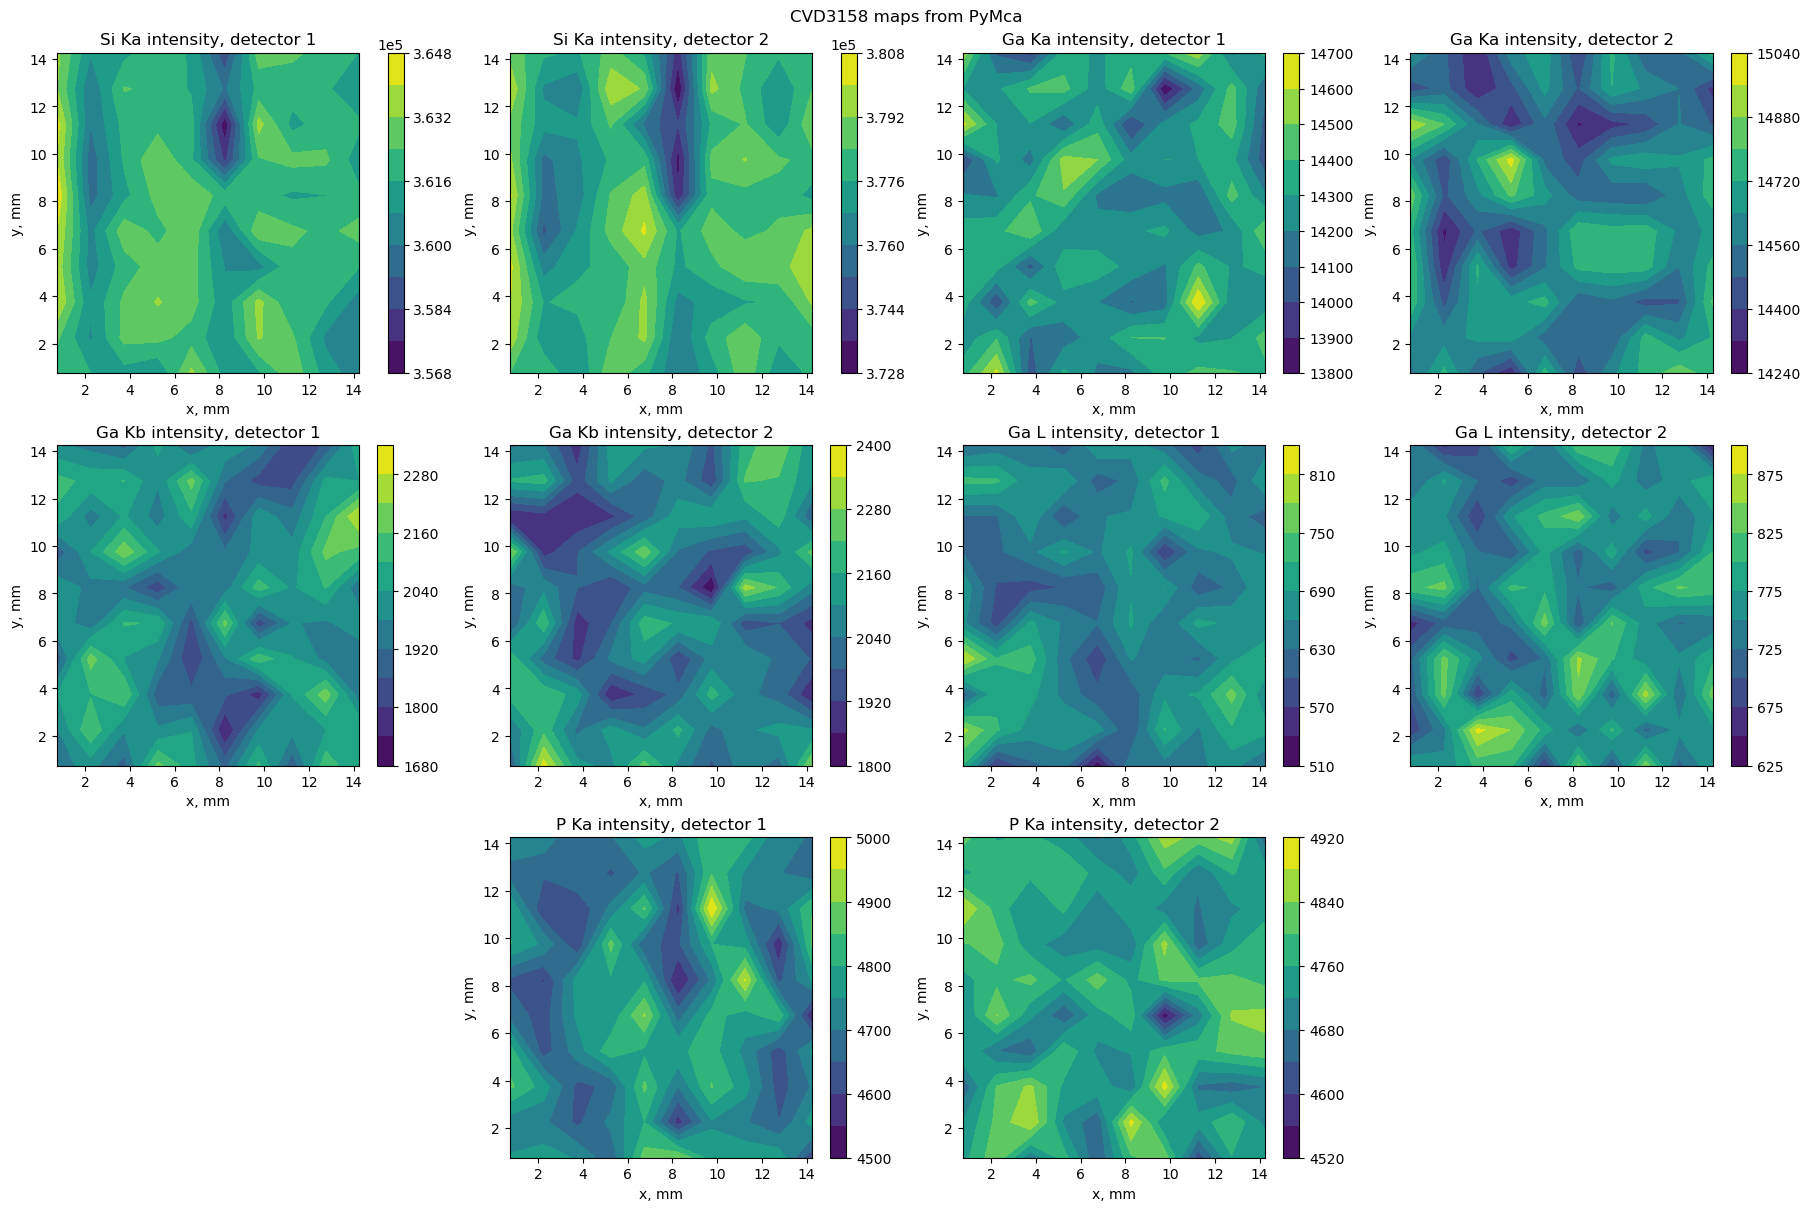

In [11]:
c="viridis" #colormap to use

#cs = {"red": ((0, 0.46, 0.46), (0.5, 0.9, 0.9), (1, 0.86, 0.86)),
#      "green": ((0, 0.57, 0.57), (0.5, 0.88, 0.88), (1, 0.2, 0.2)),
#      "blue": ((0, 0.85, 0.85), (0.5, 0.86, 0.86), (1, 0.53, 0.53))}

#c = colors.LinearSegmentedColormap("b", cs)

l = 10 #how many levels in the contour map

fg, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), layout="constrained")

def drawMap(a, dat, cm, levs, title):
    """draw contour plot
    dat is array of data to draw
    a is axes on which to draw it
    cm is the color map to use
    title is the title to write
    """
    im_pointer = a.contourf(dat, levels = levs, extent = [0, grid_dim, 0, grid_dim], cmap=cm, origin = "lower")
    cb = plt.colorbar(im_pointer, ax=a)
    cb.formatter.set_powerlimits((-5,5))
    a.set_title(title)
    a.set_xlabel("x, mm")
    a.set_ylabel("y, mm")

drawMap(axs[0][0], dat["Si_ka_d1"], c, l, "Si Ka intensity, detector 1")
drawMap(axs[0][1], dat["Si_ka_d2"], c, l, "Si Ka intensity, detector 2")

drawMap(axs[0][2], dat["Ga_ka_d1"], c, l, "Ga Ka intensity, detector 1")
drawMap(axs[0][3], dat["Ga_ka_d2"], c, l, "Ga Ka intensity, detector 2")

drawMap(axs[1][0], dat["Ga_kb_d1"], c, l, "Ga Kb intensity, detector 1")
drawMap(axs[1][1], dat["Ga_kb_d2"], c, l, "Ga Kb intensity, detector 2")

drawMap(axs[1][2], dat["Ga_l_d1"], c, l, "Ga L intensity, detector 1")
drawMap(axs[1][3], dat["Ga_l_d2"], c, l, "Ga L intensity, detector 2")

drawMap(axs[2][1], dat["P_ka_d1"], c, l, "P Ka intensity, detector 1")
drawMap(axs[2][2], dat["P_ka_d2"], c, l, "P Ka intensity, detector 2")

axs[2][0].set_axis_off()
axs[2][0].set_frame_on(False)

axs[2][3].set_axis_off()
axs[2][3].set_frame_on(False)

fg.suptitle(sample_name + " maps from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_intensity_contour_map_" + source + ".png",
            dpi="figure",
            format="png")

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right

## Pixelated map
This cell plots the data with `imshow()`, resulting in a pixelated plot with a continuous color scale.

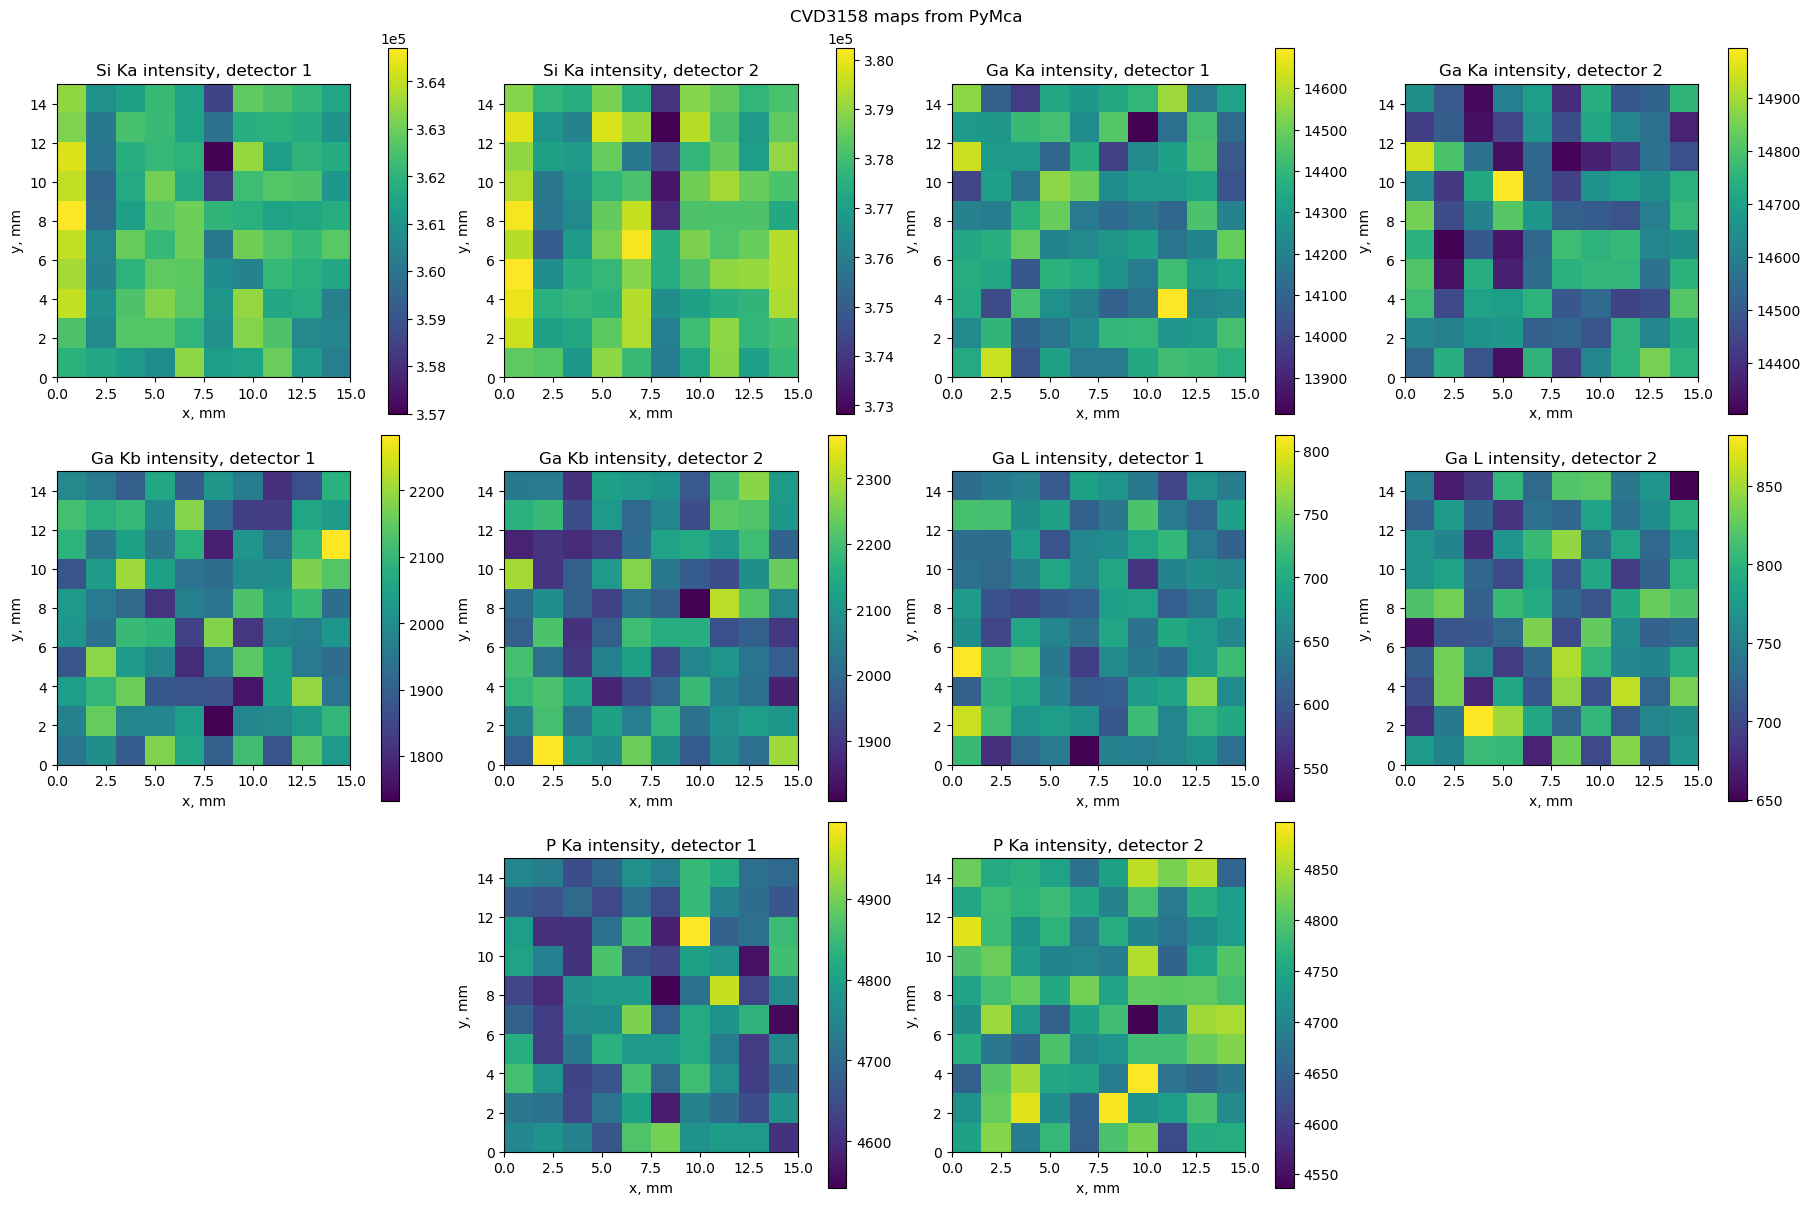

In [12]:
c="viridis"

fg, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), layout="constrained")

def drawPix(a, dat, cm, title):
    """draw pixelated heatmap
    dat is array of data to draw
    a is axes on which to draw it
    cm is the color map to use
    title is the title to write
    """
    im_pointer = a.imshow(dat, extent = [0, grid_dim, 0, grid_dim], cmap = cm, origin = "lower")
    cb = plt.colorbar(im_pointer, ax=a)
    cb.formatter.set_powerlimits((-5,5))
    a.set_title(title)
    a.set_xlabel("x, mm")
    a.set_ylabel("y, mm")

drawPix(axs[0][0], dat["Si_ka_d1"], c, "Si Ka intensity, detector 1")
drawPix(axs[0][1], dat["Si_ka_d2"], c, "Si Ka intensity, detector 2")

drawPix(axs[0][2], dat["Ga_ka_d1"], c, "Ga Ka intensity, detector 1")
drawPix(axs[0][3], dat["Ga_ka_d2"], c, "Ga Ka intensity, detector 2")

drawPix(axs[1][0], dat["Ga_kb_d1"], c, "Ga Kb intensity, detector 1")
drawPix(axs[1][1], dat["Ga_kb_d2"], c, "Ga Kb intensity, detector 2")

drawPix(axs[1][2], dat["Ga_l_d1"], c, "Ga L intensity, detector 1")
drawPix(axs[1][3], dat["Ga_l_d2"], c, "Ga L intensity, detector 2")

drawPix(axs[2][1], dat["P_ka_d1"], c, "P Ka intensity, detector 1")
drawPix(axs[2][2], dat["P_ka_d2"], c, "P Ka intensity, detector 2")

axs[2][0].set_axis_off()
axs[2][0].set_frame_on(False)

axs[2][3].set_axis_off()
axs[2][3].set_frame_on(False)

fg.suptitle(sample_name + " maps from " + source)

plt.savefig("./" + path_label + "_map/results_out/" + path_label + "_intensity_pixel_map_" + source + ".png",
            dpi="figure",
            format="png")

#for contourf(), [0][0] is displayed in the bottom left, [0][9] is in the bottom right
#for imshow(), [0][0] is displayed in the top left, [0][9] is in the top right